In [55]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import gc

## scrapper
!pip install google_play_scraper
from google_play_scraper import reviews_all, Sort

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install wordcloud
import wordcloud

## for text processing
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

## for sentiment
!pip install textblob
from textblob import TextBlob

## for vectorizer
from sklearn import feature_extraction, manifold

## for predict
!pip install transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import logging
!pip install torch
import torch


[nltk_data] Downloading package stopwords to C:\Users\Muarrikh
[nltk_data]     Yazka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Muarrikh
[nltk_data]     Yazka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Muarrikh
[nltk_data]     Yazka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<h2>Scrapping</h2>

In [3]:
## input application package name
app_package_name = 'com.netflix.ninja'

## run scrapping
result = reviews_all(
    app_package_name,
    sleep_milliseconds=2, # defaults to 0
    lang='en', # defaults to 'en'
    country='us', # defaults to 'us'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [4]:
## checking
len(result)

329

<h2>Exploration</h2>

In [5]:
## assign dataframe
df_raw = pd.DataFrame.from_records(result)

In [6]:
## assign dataframe
df = df_raw.copy()

In [7]:
## checking
df.head()

reviewId       userName  \
0  ca059b2e-d88f-4d68-97c0-0da36a325729     Shona Weir   
1  2caceb01-d089-40eb-92cc-bc7eefbd2c26  Saoirse Kelly   
2  338fcd11-6a2d-476d-95da-bbdf66a51b46            N A   
3  d86ec456-93de-41bf-8eba-8bd28e5463d1   Pichon Snchz   
4  58051d10-0738-4dd1-91b5-55c5f8009f5e   Evan McGuire   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/AD5-W...   
1  https://play-lh.googleusercontent.com/a-/AD5-W...   
2  https://play-lh.googleusercontent.com/a-/AD5-W...   
3  https://play-lh.googleusercontent.com/a-/AD5-W...   
4  https://play-lh.googleusercontent.com/a/AEdFTp...   

                                             content  score  thumbsUpCount  \
0  I love this app I can watch my favourite movie...      5              0   
1  Very difficult to navigate app on Chromecast a...      1              5   
2                             bloatware can't delete      1              0   
3                       does not support Xgimi in 4k      1              0   
4                               app forever crashing      1              0   

  reviewCreatedVersion                  at replyContent repliedAt  
0    9.0.5 build 11217 2023-01-10 03:06:36         None      None  
1    9.0.5 build 11217 2023-01-06 06:37:20         None      None  
2     8.3.2 build 4580 2023-01-02 02:22:49         None      None  
3    9.0.5 build 11217 2023-01-02 01:41:04         None      None  
4     8.3.4 build 4625 2022-12-30 18:04:55         None      None

In [8]:
## checking
df.shape

(329, 10)

In [9]:
## checking
df.dtypes

reviewId                        object
userName                        object
userImage                       object
content                         object
score                            int64
thumbsUpCount                    int64
reviewCreatedVersion            object
at                      datetime64[ns]
replyContent                    object
repliedAt                       object
dtype: object

In [10]:
## checking
df.score.unique()

array([5, 1, 2, 3, 4], dtype=int64)

In [11]:
## checking
min(df['at'])

Timestamp('2014-07-26 15:54:17')

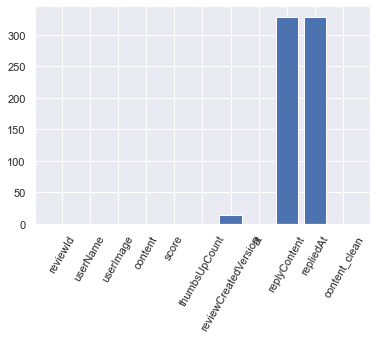

reviewId                  0
userName                  0
userImage                 0
content                   0
score                     0
thumbsUpCount             0
reviewCreatedVersion     13
at                        0
replyContent            329
repliedAt               329
content_clean             0
dtype: int64

In [56]:
## check missing value
nans = df.isna().sum()
nans_x = nans.index.to_list()
nans_y = nans.values
plt.bar(nans_x, nans_y)
plt.xticks(rotation=60)
plt.show()
display(nans)

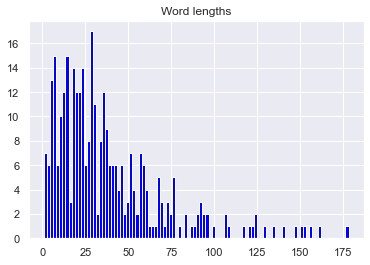

In [57]:
## calculate word length
review_len=df['content'].str.split().map(lambda x: len(x))
plt.hist(review_len,color='blue', bins=100)
plt.title('Word lengths')
plt.show()

<h2>Preprocessing</h2>

In [15]:
## function to do all preprocessing
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [16]:
## appying function
lst_stopwords = nltk.corpus.stopwords.words("english")
df['content_clean'] = df['content'].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

In [17]:
## checking
df.head()

reviewId       userName  \
0  ca059b2e-d88f-4d68-97c0-0da36a325729     Shona Weir   
1  2caceb01-d089-40eb-92cc-bc7eefbd2c26  Saoirse Kelly   
2  338fcd11-6a2d-476d-95da-bbdf66a51b46            N A   
3  d86ec456-93de-41bf-8eba-8bd28e5463d1   Pichon Snchz   
4  58051d10-0738-4dd1-91b5-55c5f8009f5e   Evan McGuire   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/AD5-W...   
1  https://play-lh.googleusercontent.com/a-/AD5-W...   
2  https://play-lh.googleusercontent.com/a-/AD5-W...   
3  https://play-lh.googleusercontent.com/a-/AD5-W...   
4  https://play-lh.googleusercontent.com/a/AEdFTp...   

                                             content  score  thumbsUpCount  \
0  I love this app I can watch my favourite movie...      5              0   
1  Very difficult to navigate app on Chromecast a...      1              5   
2                             bloatware can't delete      1              0   
3                       does not support Xgimi in 4k      1              0   
4                               app forever crashing      1              0   

  reviewCreatedVersion                  at replyContent repliedAt  \
0    9.0.5 build 11217 2023-01-10 03:06:36         None      None   
1    9.0.5 build 11217 2023-01-06 06:37:20         None      None   
2     8.3.2 build 4580 2023-01-02 02:22:49         None      None   
3    9.0.5 build 11217 2023-01-02 01:41:04         None      None   
4     8.3.4 build 4625 2022-12-30 18:04:55         None      None   

                                       content_clean  
0                love app watch favourite movie show  
1  difficult navigate app chromecast app phone ap...  
2                              bloatware cant delete  
3                                   support xgimi 4k  
4                               app forever crashing

<h2>Simple Analysis</h2>

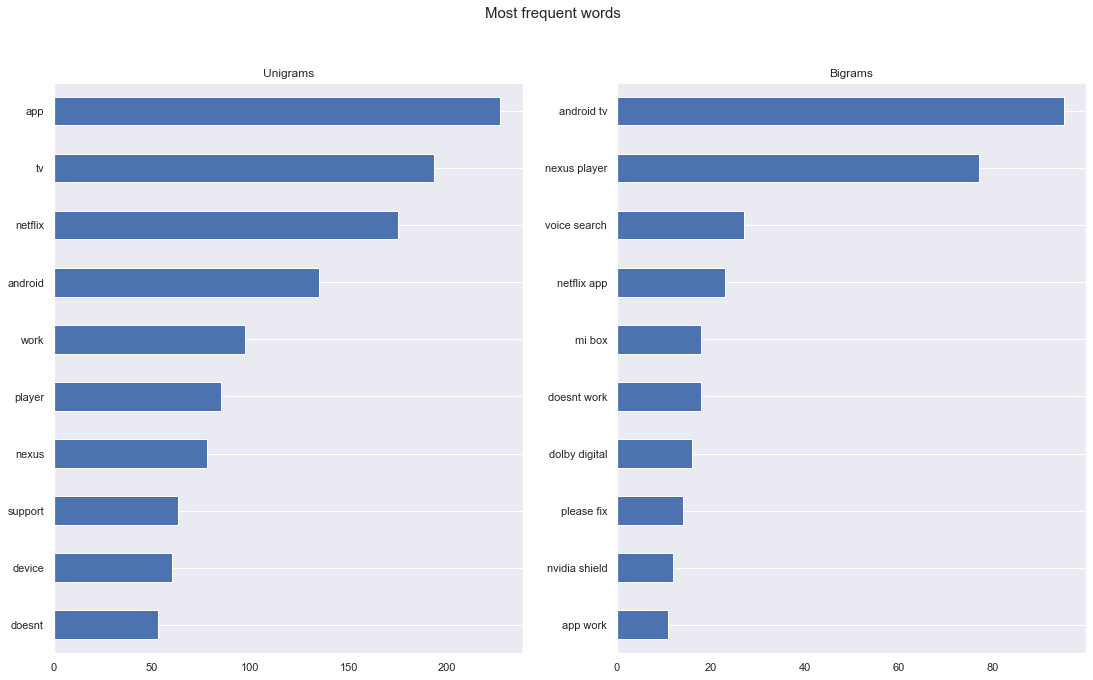

In [58]:
## convert to corpus
top=10
corpus = df["content_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))


fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Most frequent words", fontsize=15)
fig.set_size_inches(18.5, 10.5)
    
## calculate words unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## calculate words bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

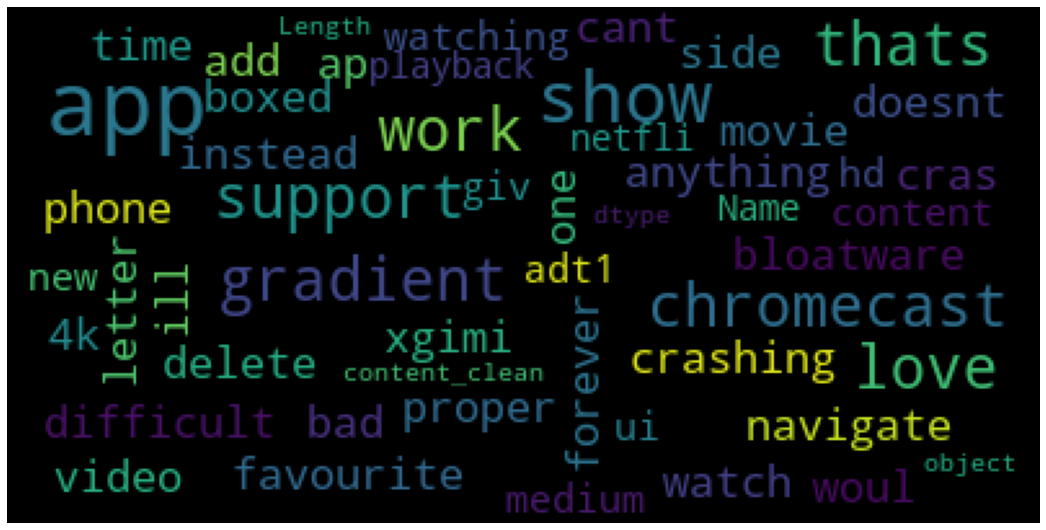

In [53]:
## create wordcloud
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
fig.set_size_inches(18.5, 10.5)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

<h2>Modeling</h2>

<h3>Topic Classification</h3>

In [21]:
## define label
idx_to_label = {
    0: 'CONTENT',
    1: 'INTERFACE',
    2: 'SUBSCRIPTION',
    3: 'USER_EXPERIENCE'}

In [22]:
## load model and tokenizer
token = '---------------------------------'

model = AutoModelForSequenceClassification.from_pretrained("alperiox/autonlp-user-review-classification-536415182", use_auth_token=token)

tokenizer = AutoTokenizer.from_pretrained("alperiox/autonlp-user-review-classification-536415182", use_auth_token=token)

In [23]:
## function to predict
def predict(texts, model, tokenizer, dictionary):
    if type(texts)==str:
            texts = [texts]

    tokenized = tokenizer(texts, truncation=True, padding=True, return_tensors='pt').to(model.device)
    
    with torch.no_grad():
        output_logits = model(**tokenized).logits

    predictions = torch.argmax(output_logits, dim=-1).cpu().numpy()

    labeled_preds = [dictionary[prediction] for prediction in predictions]
    return labeled_preds

In [24]:
## run predict
preds = predict(df['content_clean'].tolist(), model, tokenizer, idx_to_label)

In [26]:
## check
print(set(preds))

{'USER_EXPERIENCE', 'SUBSCRIPTION', 'INTERFACE', 'CONTENT'}


In [27]:
## assign predict result to main dataframe
df_after_predict = df.copy()
df_after_predict['predicted_category'] = preds

In [28]:
## checking
df_after_predict.head()

reviewId       userName  \
0  ca059b2e-d88f-4d68-97c0-0da36a325729     Shona Weir   
1  2caceb01-d089-40eb-92cc-bc7eefbd2c26  Saoirse Kelly   
2  338fcd11-6a2d-476d-95da-bbdf66a51b46            N A   
3  d86ec456-93de-41bf-8eba-8bd28e5463d1   Pichon Snchz   
4  58051d10-0738-4dd1-91b5-55c5f8009f5e   Evan McGuire   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/AD5-W...   
1  https://play-lh.googleusercontent.com/a-/AD5-W...   
2  https://play-lh.googleusercontent.com/a-/AD5-W...   
3  https://play-lh.googleusercontent.com/a-/AD5-W...   
4  https://play-lh.googleusercontent.com/a/AEdFTp...   

                                             content  score  thumbsUpCount  \
0  I love this app I can watch my favourite movie...      5              0   
1  Very difficult to navigate app on Chromecast a...      1              5   
2                             bloatware can't delete      1              0   
3                       does not support Xgimi in 4k      1              0   
4                               app forever crashing      1              0   

  reviewCreatedVersion                  at replyContent repliedAt  \
0    9.0.5 build 11217 2023-01-10 03:06:36         None      None   
1    9.0.5 build 11217 2023-01-06 06:37:20         None      None   
2     8.3.2 build 4580 2023-01-02 02:22:49         None      None   
3    9.0.5 build 11217 2023-01-02 01:41:04         None      None   
4     8.3.4 build 4625 2022-12-30 18:04:55         None      None   

                                       content_clean predicted_category  
0                love app watch favourite movie show    USER_EXPERIENCE  
1  difficult navigate app chromecast app phone ap...          INTERFACE  
2                              bloatware cant delete          INTERFACE  
3                                   support xgimi 4k          INTERFACE  
4                               app forever crashing    USER_EXPERIENCE

<h3>Sentiment Classification</h3>

In [29]:
## define label
idx_to_label_sentiments = {
    0: 'NEGATIVE',
    1: 'NEUTRAL',
    2: 'POSITIVE'
}

In [30]:
contents = df['content_clean'].to_list()

# predict 250 samples per step
# the calculations should be done in GPU if it is possible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

predictions = []
sentiment_predictions = []
size = 250

# also load the sentiment analysis model
sentiment_model_name = 'cardiffnlp/twitter-roberta-base-sentiment'

sentimental_analysis_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name)
sa_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)

# change to evaluation mode and move the models to the preferred device
model.to(device)
model.eval()

sentimental_analysis_model.eval()
sentimental_analysis_model.to(device)

## run predict
for i in tqdm(range(0, len(contents), size)):
    subset = contents[i:i+size]
    preds = predict(subset, model, tokenizer, idx_to_label)
    sa_preds = predict(subset, sentimental_analysis_model, sa_tokenizer, idx_to_label_sentiments)
    predictions.extend(preds)
    sentiment_predictions.extend(sa_preds)
    # free some memory for the next step
    del preds, sa_preds
    gc.collect()


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:27<00:00, 43.96s/it]


In [31]:
## assign predict result to main dataframe
df_after_predict['sentiment'] = sentiment_predictions

In [32]:
## checking
df_after_predict.head()

reviewId       userName  \
0  ca059b2e-d88f-4d68-97c0-0da36a325729     Shona Weir   
1  2caceb01-d089-40eb-92cc-bc7eefbd2c26  Saoirse Kelly   
2  338fcd11-6a2d-476d-95da-bbdf66a51b46            N A   
3  d86ec456-93de-41bf-8eba-8bd28e5463d1   Pichon Snchz   
4  58051d10-0738-4dd1-91b5-55c5f8009f5e   Evan McGuire   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/AD5-W...   
1  https://play-lh.googleusercontent.com/a-/AD5-W...   
2  https://play-lh.googleusercontent.com/a-/AD5-W...   
3  https://play-lh.googleusercontent.com/a-/AD5-W...   
4  https://play-lh.googleusercontent.com/a/AEdFTp...   

                                             content  score  thumbsUpCount  \
0  I love this app I can watch my favourite movie...      5              0   
1  Very difficult to navigate app on Chromecast a...      1              5   
2                             bloatware can't delete      1              0   
3                       does not support Xgimi in 4k      1              0   
4                               app forever crashing      1              0   

  reviewCreatedVersion                  at replyContent repliedAt  \
0    9.0.5 build 11217 2023-01-10 03:06:36         None      None   
1    9.0.5 build 11217 2023-01-06 06:37:20         None      None   
2     8.3.2 build 4580 2023-01-02 02:22:49         None      None   
3    9.0.5 build 11217 2023-01-02 01:41:04         None      None   
4     8.3.4 build 4625 2022-12-30 18:04:55         None      None   

                                       content_clean predicted_category  \
0                love app watch favourite movie show    USER_EXPERIENCE   
1  difficult navigate app chromecast app phone ap...          INTERFACE   
2                              bloatware cant delete          INTERFACE   
3                                   support xgimi 4k          INTERFACE   
4                               app forever crashing    USER_EXPERIENCE   

  sentiment  
0  POSITIVE  
1  NEGATIVE  
2  NEGATIVE  
3   NEUTRAL  
4  NEGATIVE

<AxesSubplot:xlabel='sentiment', ylabel='score'>

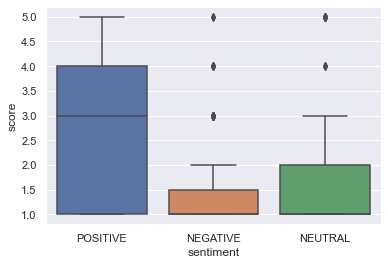

In [63]:
## boxplot as validation to compare sentiment and score in review
sns.boxplot(y = df_after_predict['score'], x = df_after_predict['sentiment'])

In [39]:
## group by 'predicted_category', 'sentiment'
df_grouped = df_after_predict.groupby(['predicted_category', 'sentiment'])['reviewId'].count().reset_index()
df_grouped.columns = ['predicted_category', 'sentiment', 'count']

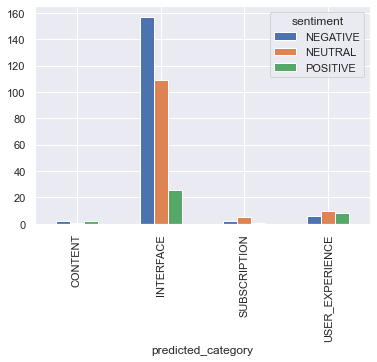

In [59]:
## charting
df_grouped.pivot('predicted_category', 'sentiment', 'count').plot(kind='bar')
plt.show()